In [1]:
import numpy as np
import scipy as sp

import autograd

import sys
sys.path.insert(0, './../../LinearResponseVariationalBayes.py')
sys.path.insert(0, './../src/vb_modeling/')

import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.ExponentialFamilies as ef

from numpy.polynomial.hermite import hermgauss

import gmm_clustering_lib as gmm_utils
from shift_only_lib import LinearSensitivity
import common_modeling_lib 
 

from scipy import spatial
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
%matplotlib inline

import time
from tqdm import tqdm

from copy import deepcopy

from matplotlib.patches import Ellipse
import matplotlib.cm as cm

import os

np.random.seed(453453)


import json
import json_tricks
import checkpoints
from checkpoints import np_string

from stability_utils import get_expected_mutual_info, get_fowlkes_mallows_score


def comparison_plot(x, y): 
    plt.plot(x, y, 'r+')
    plt.plot(x, x)

# Load data

In [2]:
# set up R chunks 
# %load_ext rpy2.ipython
# %R require(ggplot2)

In [3]:
# load iris dataset 

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

iris = datasets.load_iris(return_X_y= True)

iris_features = iris[0]

demean = True
if demean: 
    iris_features -= np.mean(iris_features, axis = 0)[None, :]

iris_species = iris[1]

dim = iris_features.shape[1]

In [4]:
# define colors that will be used for plotting later
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta']
# colors += colors

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

In [5]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_features)
pc_features = pca_fit.transform(iris_features)

In [6]:
def plot_clusters(x, y, cluster_labels, colors, fig, centroids = None, cov = None): 
    if np.all(cov != None): 
        assert len(np.unique(cluster_labels)) == np.shape(cov)[0]
    if np.all(centroids != None): 
        assert len(np.unique(cluster_labels)) == np.shape(centroids)[1] 
    
    unique_cluster_labels = np.unique(cluster_labels)
    n_clusters = len(unique_cluster_labels)
        
    # this would be so much easier if 
    # python lists supported logical indexing ... 
    cluster_labels_color = [colors[k] for n in range(len(x)) \
                            for k in range(n_clusters) \
                            if cluster_labels[n] == unique_cluster_labels[k]]
            
    # plot datapoints
    fig.scatter(x, y, c=cluster_labels_color, marker = '.')
    
    if np.all(centroids != None): 
        for k in range(n_clusters): 
            fig.scatter(centroids[0, k], centroids[1, k], marker = '+', color = 'black')
    
    if np.all(cov != None): 
        for k in range(n_clusters):  
            eig, v = np.linalg.eig(cov[k, :, :])
            ell = Ellipse(xy=(centroids[0, k], centroids[1, k]),
                  width=np.sqrt(eig[0]) * 6, height=np.sqrt(eig[1]) * 6,
                  angle=np.rad2deg(np.arctan(v[1, 0] / v[0, 0])))
            ell.set_facecolor('none')
            ell.set_edgecolor(colors[k])
            fig.add_artist(ell)
                

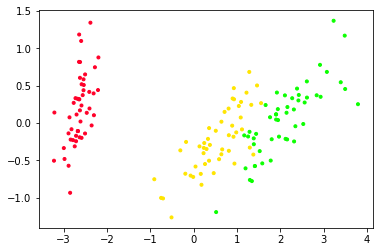

In [7]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)

In [8]:
def transform_params_to_pc_space(pca_fit, centroids, cov):
    # centroids is dim x k_approx
    # infos is k_approx x dim x dim

    assert pca_fit.components_.shape[1] == centroids.shape[0]
    
    centroids_pc = pca_fit.transform(centroids.T)
    
    cov_pc = np.zeros(cov.shape)
    for k in range(cov.shape[0]):
        cov_pc[k, :, :] = np.dot(np.dot(pca_fit.components_, cov[k]), pca_fit.components_.T)
        
    # cov_pc = np.einsum('di, kij, ej -> kde', pca_fit.components_, cov, pca_fit.components_)
    
    
    return centroids_pc.T, cov_pc

# Load full models

In [9]:
full_data_fits_dir = './iris_fits/full_data_fits/'

In [10]:
os.listdir(full_data_fits_dir)

['iris_nclusters10_full_data_fit.json',
 'iris_nclusters5_full_data_fit.json',
 'iris_nclusters2_full_data_fit.json',
 'iris_nclusters4_full_data_fit.json',
 'iris_nclusters7_full_data_fit.json',
 'iris_nclusters6_full_data_fit.json',
 'iris_nclusters8_full_data_fit.json',
 'iris_bnp_full_data_fit.json',
 'iris_nclusters9_full_data_fit.json',
 'iris_nclusters3_full_data_fit.json']

In [11]:
k_approx_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]

In [12]:
full_data_models = dict()
full_vb_global_free_par_dict = dict()

In [13]:
# full_data_models are where we store the models fit to the full data for 
# each k

for k in k_approx_list: 
    file = os.path.join(full_data_fits_dir, 'iris_nclusters{}_full_data_fit.json'.format(k))
    with open(file, 'r') as fp:
        fit_dict = json.load(fp)

    full_data_models['n_clusters{}'.format(k)] = gmm_utils.get_model_from_checkpoint(fit_dict)
    
    assert full_data_models['n_clusters{}'.format(k)].use_weights == False
    
    full_vb_global_free_par_dict['n_clusters{}'.format(k)] = \
        full_data_models['n_clusters{}'.format(k)].global_vb_params.get_free()

In [14]:
models = deepcopy(full_data_models) # this is the one we will pass around
# full data models will stay the same

# look at full model fits

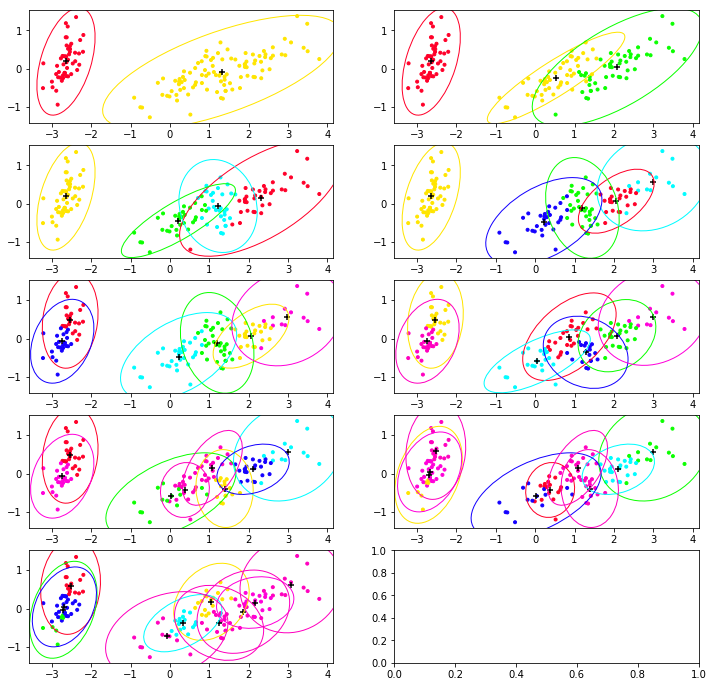

In [15]:
f, axarr = plt.subplots(5, 2, figsize = (12, 12))
i = 0
for k in k_approx_list: 
    model = full_data_models['n_clusters{}'.format(k)]
    
    bnp_clusters = np.argmax(model.vb_params['e_z'].get(), axis = 1)
    bnp_centroids = model.vb_params['global']['centroids'].get()

    bnp_cluster_infos = model.vb_params['global']['gamma'].get()
    bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)
    
    bnp_centroids_pc, bnp_cluster_covs_pc = \
    transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)
    
    indx1 = int(np.floor(i / 2))
    indx2 = int(i % 2)
    i+=1
    
    plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, axarr[indx1, indx2], \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
                  cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])
       

# Load bootstrap results

In [16]:
linf_diff = lambda x, y : np.max(np.abs(x - y))

In [17]:
def get_global_free_params_and_weights_from_fit_dict(fit_dict):
    np_string = checkpoints.np_string
    vb_global_free_par = json_tricks.loads(
            fit_dict['vb_global_free_par' + np_string])

    sample_weights = json_tricks.loads(
        fit_dict['sample_weights' + np_string])

    return {'vb_global_free_par': vb_global_free_par, \
            'sample_weights': sample_weights}


In [18]:
def load_bootstrap_results(gmm_full, result_files, print_every_n=10):

    results = []
    i = 0
    if len(result_files) == 0:
        raise ValueError('No result files were specfied.')
    for f in result_files:
        i += 1
        if (i % print_every_n) == 0:
            print('files opened: ', i)

        with open(f, 'r') as fp:
            fit_dict = json.load(fp)


            assert linf_diff(json_tricks.loads(fit_dict['prior_params_vec' + np_string]), \
                                 gmm_full.prior_params.get_vector()) < 1e-12

            # check that the length of the free params are the same ..
            assert len(json_tricks.loads(fit_dict['vb_global_free_par' + np_string])) == \
                        len(gmm_full.global_vb_params.get_free())

            # check y
            assert linf_diff(json_tricks.loads(fit_dict['y' + np_string]), gmm_full.y) < 1e-12

        results.append(get_global_free_params_and_weights_from_fit_dict(fit_dict))

    return results


In [19]:
model_explorer_dir = './iris_fits/model_explorer_results/'

In [20]:
# boot_results_dict contains the dictionary with bootstrap fits
# for each k

In [21]:
boot_results_dict = dict()

for k in k_approx_list: 
    print('loading bootstrap results for k = {}'.format(k))
    
    result_files = [os.path.join(model_explorer_dir, f) for f in os.listdir(model_explorer_dir) if \
                            os.path.isfile(os.path.join(model_explorer_dir, f)) & \
                            f.endswith('.json') & \
                            ('nclusters{}'.format(k) in f)]

    
    boot_results_dict['n_clusters{}'.format(k)] = \
        load_bootstrap_results(models['n_clusters{}'.format(k)], result_files, print_every_n=50)
    

loading bootstrap results for k = 2
files opened:  50
files opened:  100
files opened:  150
files opened:  200
loading bootstrap results for k = 3
files opened:  50
files opened:  100
files opened:  150
files opened:  200
loading bootstrap results for k = 4
files opened:  50
files opened:  100
files opened:  150
files opened:  200
loading bootstrap results for k = 5
files opened:  50
files opened:  100
files opened:  150
files opened:  200
loading bootstrap results for k = 6
files opened:  50
files opened:  100
files opened:  150
files opened:  200
loading bootstrap results for k = 7
files opened:  50
files opened:  100
files opened:  150
files opened:  200
loading bootstrap results for k = 8
files opened:  50
files opened:  100
files opened:  150
files opened:  200
loading bootstrap results for k = 9
files opened:  50
files opened:  100
files opened:  150
loading bootstrap results for k = 10
files opened:  50
files opened:  100
files opened:  150
files opened:  200


# Checkout stabilities

In [22]:
def get_ez_from_free_param(model, global_free_vb_params):
    model.global_vb_params.set_free(global_free_vb_params)
    model.set_optimal_z()
    
    return model.vb_params['e_z'].get()

In [23]:
def get_iqr(x): 
    return np.percentile(x, 75) - np.percentile(x, 25)

In [24]:
def get_stabilities_from_boot_results(model, full_vb_global_free_pars, \
                                      boot_vb_global_free_pars, return_full_array = False):
       
    fm_scores = np.zeros(len(boot_vb_global_free_pars))
    emi_scores = np.zeros(len(boot_vb_global_free_pars))

    for b in range(len(boot_vb_global_free_pars)): 
        e_z_full = get_ez_from_free_param(model, \
                               full_vb_global_free_pars)

        e_z_boot = get_ez_from_free_param(model, \
                               boot_vb_global_free_pars[b])

        fm_scores[b] = get_fowlkes_mallows_score(e_z_full, e_z_boot)
        emi_scores[b] = get_expected_mutual_info(e_z_full, e_z_boot)
        
    if return_full_array: 
        return fm_scores, emi_scores
    else: 
        return np.median(fm_scores), np.percentile(fm_scores, 75), np.percentile(fm_scores, 25),\
                np.median(emi_scores), np.percentile(emi_scores, 75), np.percentile(emi_scores, 25)
    

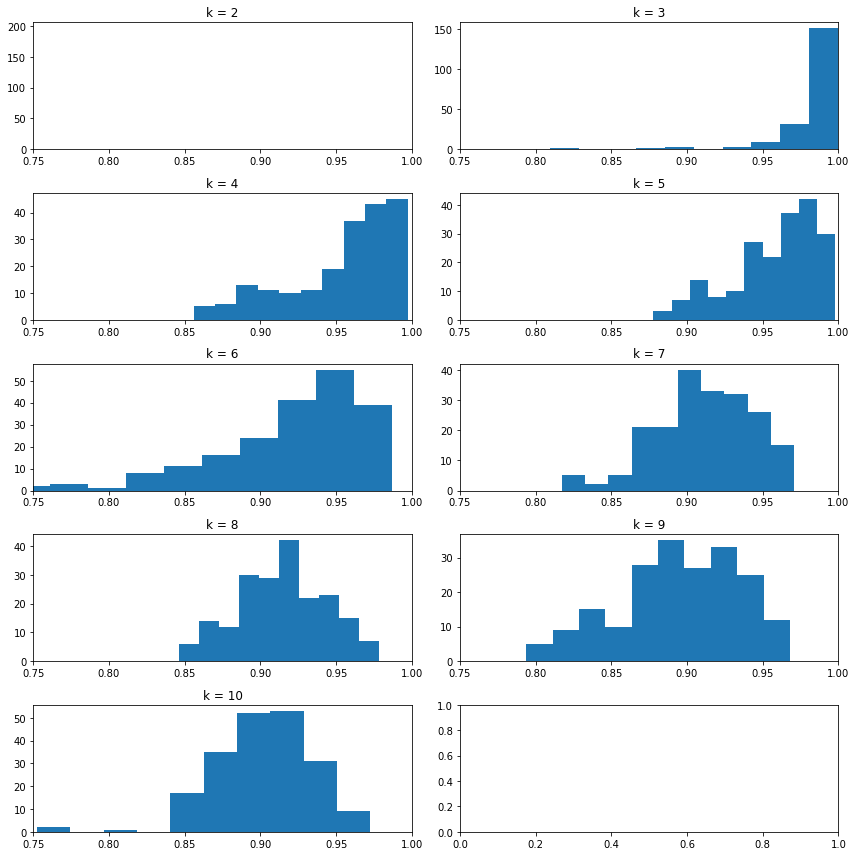

In [25]:
f, axarr = plt.subplots(5, 2, figsize = (12, 12))
i = 0
for k in k_approx_list: 
    
    model = models['n_clusters{}'.format(k)]
    full_vb_global_free_pars = full_data_models['n_clusters{}'.format(k)].global_vb_params.get_free()
    boot_vb_global_free_pars = np.array([x['vb_global_free_par'] for \
                                        x in boot_results_dict['n_clusters{}'.format(k)] ])
    
    fm_scores, emi_scores = \
        get_stabilities_from_boot_results(model, full_vb_global_free_pars, \
                                          boot_vb_global_free_pars, return_full_array=True)
    
    axarr[int(np.floor(i/2)), int(i%2)].hist(fm_scores)
    axarr[int(np.floor(i/2)), int(i%2)].set_xlim((0.75, 1))
    axarr[int(np.floor(i/2)), int(i%2)].set_title('k = {}'.format(k))
    
    i += 1
    
    
    
f.tight_layout()

In [26]:
med_fm_scores = np.zeros(len(k_approx_list))
upper_q_fm_scores = np.zeros(len(k_approx_list))
lower_q_fm_scores = np.zeros(len(k_approx_list))

med_emi_scores = np.zeros(len(k_approx_list))
upper_q_emi_scores = np.zeros(len(k_approx_list))
lower_q_emi_scores = np.zeros(len(k_approx_list))

i=0
for k in k_approx_list: 
    model = models['n_clusters{}'.format(k)]
    full_vb_global_free_pars = full_data_models['n_clusters{}'.format(k)].global_vb_params.get_free()
    boot_vb_global_free_pars = np.array([x['vb_global_free_par'] for \
                                        x in boot_results_dict['n_clusters{}'.format(k)] ])
    
    med_fm_scores[i], upper_q_fm_scores[i], lower_q_fm_scores[i], \
    med_emi_scores[i], upper_q_emi_scores[i], lower_q_emi_scores[i] = \
        get_stabilities_from_boot_results(model, full_vb_global_free_pars, \
                                          boot_vb_global_free_pars, return_full_array=False)
    
    i += 1

    
    

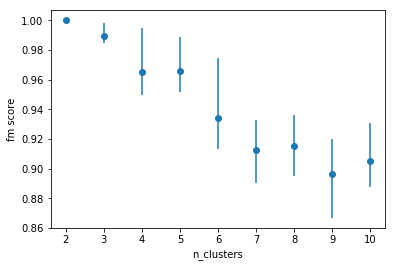

In [27]:
# plt.scatter(k_approx_list, med_fm_scores)
plt.errorbar(k_approx_list, med_fm_scores, \
             yerr=[upper_q_fm_scores - med_fm_scores, med_fm_scores - lower_q_fm_scores], fmt='o')
plt.xlabel('n_clusters')
plt.ylabel('fm score')

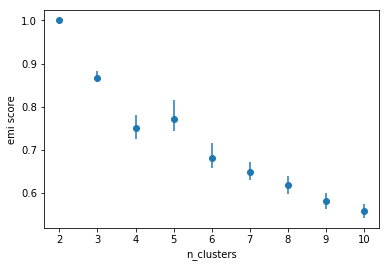

In [28]:
plt.errorbar(k_approx_list, med_emi_scores, \
             yerr=[upper_q_emi_scores - med_emi_scores, med_emi_scores - lower_q_emi_scores], fmt='o')
plt.xlabel('n_clusters')
plt.ylabel('emi score')

# See how well LRVB matches these results

In [29]:
linear_sens_dict = dict()
for k in k_approx_list: 
    
    print('linear response for model with k = {}'.format(k))
    
    model = deepcopy(full_data_models['n_clusters{}'.format(k)])
    
    moment_model = gmm_utils.InterestingMoments(model)
    linear_sens_dict['n_clusters{}'.format(k)] = LinearSensitivity(model, moment_model)

linear response for model with k = 2
KL Hessian:
Prior Hessian...
Data Hessian...
Linear systems...
Done.
linear response for model with k = 3
KL Hessian:
Prior Hessian...
Data Hessian...
Linear systems...
Done.
linear response for model with k = 4
KL Hessian:
Prior Hessian...
Data Hessian...
Linear systems...
Done.
linear response for model with k = 5
KL Hessian:
Prior Hessian...
Data Hessian...
Linear systems...
Done.
linear response for model with k = 6
KL Hessian:
Prior Hessian...
Data Hessian...
Linear systems...
Done.
linear response for model with k = 7
KL Hessian:
Prior Hessian...
Data Hessian...
Linear systems...
Done.
linear response for model with k = 8
KL Hessian:
Prior Hessian...
Data Hessian...
Linear systems...
Done.
linear response for model with k = 9
KL Hessian:
Prior Hessian...
Data Hessian...
Linear systems...
Done.
linear response for model with k = 10
KL Hessian:
Prior Hessian...
Data Hessian...
Linear systems...
Done.


In [30]:
for k in k_approx_list: 
    full_data_models['n_clusters{}'.format(k)].global_vb_params.set_free(
        full_vb_global_free_par_dict['n_clusters{}'.format(k)])
    
    models['n_clusters{}'.format(k)].global_vb_params.set_free(
        full_vb_global_free_par_dict['n_clusters{}'.format(k)])

### Check one bootstrap sample

In [31]:
def get_ij_estimate(linear_sens, sample_weights): 
    n_obs = np.shape(sample_weights)[0]
    return np.dot(linear_sens.data_sens_mat, \
                  sample_weights - np.ones((n_obs, 1))).flatten() + \
            linear_sens.optimal_global_free_params 

In [32]:
def run_lr_bootstrap(linear_sens, sample_weights_list): 
    n_boot = len(sample_weights_list)
    
    dim_free_pars = len(linear_sens.model.global_vb_params.get_free())
    
    lr_vb_global_free_pars = np.zeros((n_boot, dim_free_pars))
    for i in range(n_boot):
        lr_vb_global_free_pars[i, :] = get_ij_estimate(linear_sens, sample_weights_list[i])
    
    return lr_vb_global_free_pars

In [33]:
k = 4

sample_weights_list = np.array([x['sample_weights'] \
                                for x in boot_results_dict['n_clusters{}'.format(k)]])

lr_vb_global_free_pars = run_lr_bootstrap(linear_sens_dict['n_clusters{}'.format(k)], sample_weights_list) 

In [34]:
boot_vb_global_free_pars = np.array([x['vb_global_free_par'] \
                                    for x in boot_results_dict['n_clusters{}'.format(k)]])

In [35]:
full_vb_global_free_pars = full_data_models['n_clusters{}'.format(k)].global_vb_params.get_free()

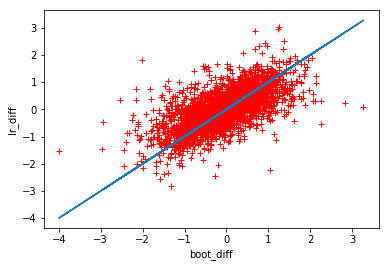

In [36]:
comparison_plot((boot_vb_global_free_pars - full_vb_global_free_pars).flatten(), 
               (lr_vb_global_free_pars - full_vb_global_free_pars).flatten())

plt.xlabel('boot_diff')
plt.ylabel('lr_diff')


### Lets get linear response estimates of the stability scores

In [37]:
k = 9
sample_weights_list = np.array([x['sample_weights'] \
                                for x in boot_results_dict['n_clusters{}'.format(k)]])

boot_vb_global_free_pars = np.array([x['vb_global_free_par'] \
                                for x in boot_results_dict['n_clusters{}'.format(k)]])

lr_vb_global_free_pars = run_lr_bootstrap(linear_sens_dict['n_clusters{}'.format(k)], sample_weights_list) 

In [38]:
lr_results = get_stabilities_from_boot_results(models['n_clusters{}'.format(k)], 
                                  full_vb_global_free_par_dict['n_clusters{}'.format(k)], \
                                lr_vb_global_free_pars, return_full_array = True)

boot_results = get_stabilities_from_boot_results(models['n_clusters{}'.format(k)], 
                                  full_vb_global_free_par_dict['n_clusters{}'.format(k)], \
                                boot_vb_global_free_pars, return_full_array = True)

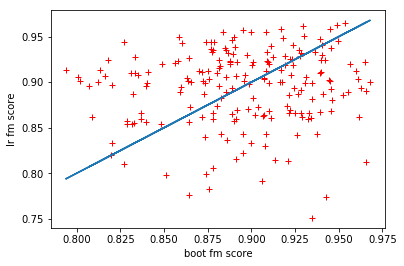

In [39]:
comparison_plot(boot_results[0], lr_results[0])
plt.xlabel('boot fm score')
plt.ylabel('lr fm score')

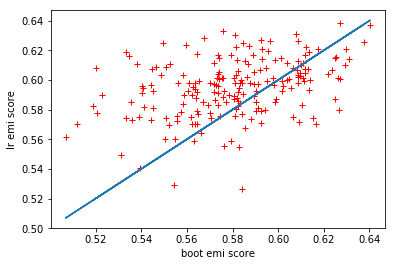

In [40]:
comparison_plot(boot_results[1], lr_results[1])
plt.xlabel('boot emi score')
plt.ylabel('lr emi score')

# LR stabilities across K ... 

In [41]:
med_fm_scores_lr = np.zeros(len(k_approx_list))
upper_q_fm_scores_lr = np.zeros(len(k_approx_list))
lower_q_fm_scores_lr = np.zeros(len(k_approx_list))

med_emi_scores_lr = np.zeros(len(k_approx_list))
upper_q_emi_scores_lr = np.zeros(len(k_approx_list))
lower_q_emi_scores_lr = np.zeros(len(k_approx_list))

i=0
for k in k_approx_list: 
    model = models['n_clusters{}'.format(k)]
    full_vb_global_free_pars = full_vb_global_free_par_dict['n_clusters{}'.format(k)]
    
    sample_weights_list = np.array([x['sample_weights'] \
                                for x in boot_results_dict['n_clusters{}'.format(k)]])

    lr_vb_global_free_pars = \
        run_lr_bootstrap(linear_sens_dict['n_clusters{}'.format(k)], sample_weights_list) 
    
    med_fm_scores_lr[i], upper_q_fm_scores_lr[i], lower_q_fm_scores_lr[i], \
    med_emi_scores_lr[i], upper_q_emi_scores_lr[i], lower_q_emi_scores_lr[i] = \
        get_stabilities_from_boot_results(model, full_vb_global_free_pars, \
                                          lr_vb_global_free_pars, return_full_array=False)
    
    i += 1

    
    

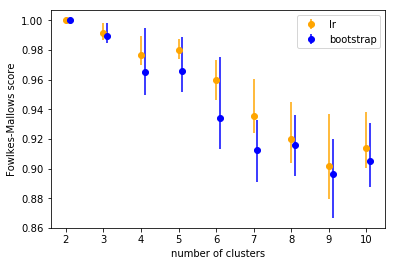

In [56]:
# Blue is lr bootstrap, red is real bootstrap

plt.errorbar(k_approx_list, med_fm_scores_lr, \
             yerr=[upper_q_fm_scores_lr - med_fm_scores_lr, med_fm_scores_lr - lower_q_fm_scores_lr], 
             fmt='o', c = 'orange')

plt.errorbar(np.array(k_approx_list)+0.1, med_fm_scores, \
             yerr=[upper_q_fm_scores - med_fm_scores, med_fm_scores - lower_q_fm_scores], 
             fmt='ob')

plt.xlabel('number of clusters')
plt.ylabel('Fowlkes-Mallows score')
plt.legend(('lr', 'bootstrap'))

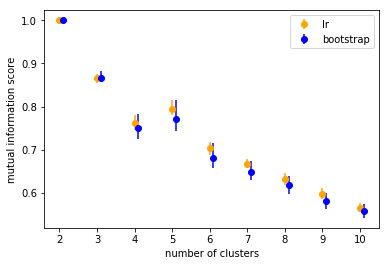

In [57]:
plt.errorbar(k_approx_list, med_emi_scores_lr, \
             yerr=[upper_q_emi_scores_lr - med_emi_scores_lr, med_emi_scores_lr - lower_q_emi_scores_lr], 
             fmt='o', c = 'orange')
plt.errorbar(np.array(k_approx_list)+0.1, med_emi_scores, \
             yerr=[upper_q_emi_scores - med_emi_scores, med_emi_scores - lower_q_emi_scores], 
             fmt='ob')

plt.xlabel('number of clusters')
plt.ylabel('mutual information score')
plt.legend(('lr', 'bootstrap'))

# Compare with BNP model

In [44]:
full_data_fit_file = './iris_fits/full_data_fits/iris_bnp_full_data_fit.json'

In [45]:
with open(full_data_fit_file, 'r') as fp:
    fit_dict = json.load(fp)

bnp_model = gmm_utils.get_model_from_checkpoint(fit_dict)

assert bnp_model.use_weights == False

bnp_global_free_param = bnp_model.global_vb_params.get_free()
prior_free_param = bnp_model.prior_params.get_free()
bnp_model.set_optimal_z()

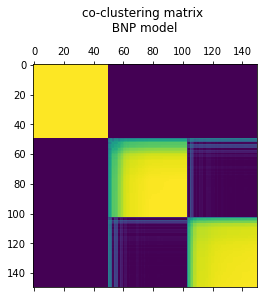

In [46]:
e_z = bnp_model.vb_params['e_z'].get()
co_cluster_mat = np.dot(e_z, e_z.T)

dis = (co_cluster_mat + 1) ** (-1)
dis[np.diag_indices_from(dis)] = 0
dis = spatial.distance.squareform(dis, checks=False)
y = sch.linkage(dis, method='average')
indx_bnp = sch.dendrogram(y, no_plot=True)["leaves"]

co_cluster_mat = co_cluster_mat[indx_bnp][:, indx_bnp]

plt.matshow(co_cluster_mat)
plt.title('co-clustering matrix \n BNP model \n')


In [47]:
k = 3
fin_mix_model = full_data_models['n_clusters{}'.format(k)]
fin_mix_model.set_optimal_z()

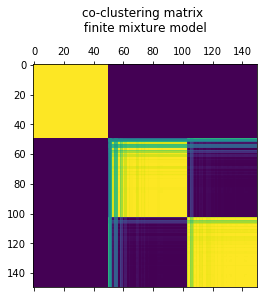

In [58]:
e_z_finite_mix = fin_mix_model.vb_params['e_z'].get()
co_cluster_mat = np.dot(e_z_finite_mix, e_z_finite_mix.T)

dis = (co_cluster_mat + 1) ** (-1)
dis[np.diag_indices_from(dis)] = 0
dis = spatial.distance.squareform(dis, checks=False)
y = sch.linkage(dis, method='average')
# indx_best = sch.dendrogram(y, no_plot=True)["leaves"]

co_cluster_mat = co_cluster_mat[indx_bnp][:, indx_bnp]

plt.matshow(co_cluster_mat)
plt.title('co-clustering matrix \n finite mixture model \n')


In [49]:
def foo(model): 
    bnp_clusters = np.argmax(model.vb_params['e_z'].get(), axis = 1)
    bnp_centroids = model.vb_params['global']['centroids'].get()

    bnp_cluster_infos = model.vb_params['global']['gamma'].get()
    bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)
    
    bnp_centroids_pc, bnp_cluster_covs_pc = \
    transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)
    
    plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
                  cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])
       

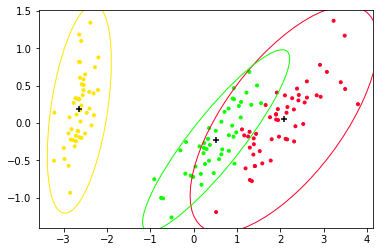

In [50]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

foo(bnp_model)

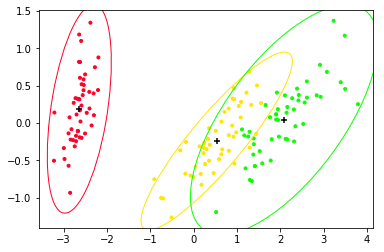

In [51]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

foo(fin_mix_model)

In [63]:
# bnp clusters
bnp_clusters = np.argmax(bnp_model.vb_params['e_z'].get(), axis = 1)
bnp_centroids = bnp_model.vb_params['global']['centroids'].get()

bnp_cluster_infos = bnp_model.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

bnp_centroids_pc, bnp_cluster_covs_pc = \
    transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)

# finite mixture clusters
fin_clusters = np.argmax(fin_mix_model.vb_params['e_z'].get(), axis = 1)
fin_centroids = fin_mix_model.vb_params['global']['centroids'].get()

fin_cluster_infos = fin_mix_model.vb_params['global']['gamma'].get()
fin_cluster_covs = np.linalg.inv(fin_cluster_infos)

fin_centroids_pc, fin_cluster_covs_pc = \
    transform_params_to_pc_space(pca_fit, fin_centroids, fin_cluster_covs)


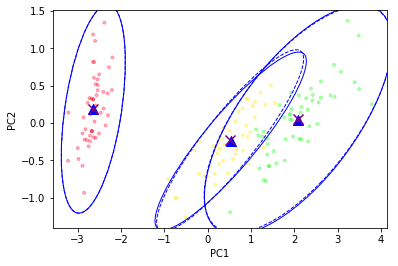

In [65]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

# plot datapoints
unique_cluster_labels = [0, 1, 2]
cluster_labels_color = [colors1[k] for n in range(len(pc_features[:, 0])) \
                        for k in range(3) \
                        if fin_clusters[n] == unique_cluster_labels[k]]

fig.scatter(pc_features[:, 0], pc_features[:, 1], c=cluster_labels_color, marker = '.', alpha = 0.3)


# Plot finite mixture centroids and covariance
plt.scatter(fin_centroids_pc[0, :], fin_centroids_pc[1, :], marker= '^', s = 100, color = 'blue')
for k_ in range(k):  
    eig, v = np.linalg.eig(fin_cluster_covs_pc[k_, :, :])
    ell = Ellipse(xy=(fin_centroids_pc[0, k_], fin_centroids_pc[1, k_]),
          width=np.sqrt(eig[0]) * 6, height=np.sqrt(eig[1]) * 6,
          angle=np.rad2deg(np.arctan(v[1, 0] / v[0, 0])))
    ell.set_facecolor('none')
    ell.set_edgecolor('blue')
    fig.add_artist(ell)


# Plot BNP centroids and covariances

plt.scatter(bnp_centroids_pc[0, np.unique(bnp_clusters)], bnp_centroids_pc[1, np.unique(bnp_clusters)], 
                marker= 'x', s = 100, color = 'purple')

unique_bnp_clust = np.unique(bnp_clusters)

for i in unique_bnp_clust:  
    eig, v = np.linalg.eig(bnp_cluster_covs_pc[i, :, :])
    ell = Ellipse(xy=(bnp_centroids_pc[0, i], bnp_centroids_pc[1, i]),
          width=np.sqrt(eig[0]) * 6, height=np.sqrt(eig[1]) * 6,
          angle=np.rad2deg(np.arctan(v[1, 0] / v[0, 0])), ls = '--')
    ell.set_facecolor('none')
    ell.set_edgecolor('blue')
    fig.add_artist(ell)

    
plt.xlabel('PC1')
plt.ylabel('PC2')